In [1]:
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import Normalizer, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
r = requests.get(url, allow_redirects=True)
open('iris.txt','wb').write(r.content)

4551

In [3]:
header = ['sepal_length','sepal_width','petal_length','petal_width','names']
df = pd.read_csv('iris.txt',names = header,index_col =False)
df.head(10)

,sepal_length,sepal_width,petal_length,petal_width,names
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [4]:
### convert string y-value into numerical, wasn't necessary, doing this due to the following function 
###plot_confusion matrix must use float value instead of string
def name_to_numeric(x):
    if x=='Iris-setosa':return 0
    if x =='Iris-versicolor':return 1
    if x =='Iris-virginica':return 2

df['names'] = df['names'].apply(name_to_numeric)

In [5]:
X = df.iloc[:,:-1]
X.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [6]:
y = (df.iloc[:,-1:])
y.head(3)

,names
0,0
1,0
2,0


In [15]:
X_train, X_test, y_train, y_test = train_test_split( X,y, test_size = 0.2, random_state = 0)

In [16]:
##one-hot encoding
y_train = tf.keras.utils.to_categorical(np.array(y_train))
y_test = tf.keras.utils.to_categorical(np.array(y_test))

In [21]:
#Model defining
def get_model(input_shape):
    """
    This function should build a Sequential model according to the above specification. Ensure the 
    weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument.
    Your function should return the model.
    """
    initializer = tf.keras.initializers.he_uniform()
    model = Sequential([
        Dense(64,input_shape=input_shape,kernel_initializer=initializer,bias_initializer='ones',activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(3,activation='softmax')
    ])
    return model

model = get_model(X_train.values[0].shape)

In [22]:
#Model compilation
def compile_model(model):
    """
    This function takes in the model returned from your get_model function, and compiles it with an optimiser,
    loss function and metric.
    Compile the model using the Adam optimiser (with learning rate set to 0.0001), 
    the categorical crossentropy loss function and accuracy as the only metric. 
    Your function doesn't need to return anything; the model will be compiled in-place.
    """
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    return model.compile(optimizer=adam,
                         loss ='categorical_crossentropy',
                         metrics=['accuracy'],
                        ) 
compile_model(model)

In [23]:
#fit 
def train_model(model, train_data, train_targets, epochs):
    """
    This function should train the model for the given number of epochs on the 
    train_data and train_targets. 
    Your function should return the training history, as returned by model.fit.
    """
    history = model.fit(train_data,train_targets,epochs=epochs,batch_size=40,validation_split=0.15,verbose = 0)
    return history

In [24]:
history = train_model(model, X_train, y_train, epochs=800)
#click the dots to expand epochs

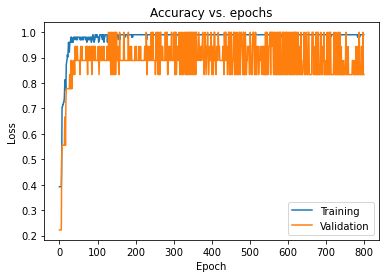

In [25]:
#plotting epoch vs accuracy graph
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

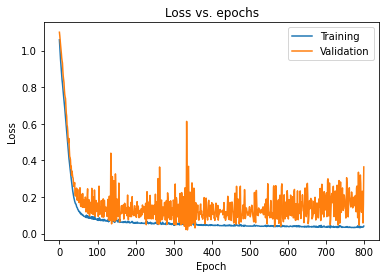

In [26]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [27]:
def get_regularised_model(input_shape, dropout_rate, weight_decay):
    """
    This function should build a regularised Sequential model according to the above specification. 
    The dropout_rate argument in the function should be used to set the Dropout rate for all Dropout layers.
    L2 kernel regularisation (weight decay) should be added using the weight_decay argument to 
    set the weight decay coefficient in all Dense layers that use L2 regularisation.
    Ensure the weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument input_shape.
    Your function should return the model.
    """
    initializer = tf.keras.initializers.he_uniform()
    model = Sequential([
        Dense(64,input_shape=input_shape,kernel_initializer=initializer,bias_initializer='ones',activation='relu',kernel_regularizer = regularizers.l2(weight_decay)),
        Dense(128,activation='relu',kernel_regularizer = regularizers.l2(weight_decay)),
        Dense(128,activation='relu',kernel_regularizer = regularizers.l2(weight_decay)),
        Dropout(dropout_rate),
        Dense(128,activation='relu',kernel_regularizer = regularizers.l2(weight_decay)),
        Dense(128,activation='relu',kernel_regularizer = regularizers.l2(weight_decay)),
        BatchNormalization(),
        Dense(64,activation='relu',kernel_regularizer = regularizers.l2(weight_decay)),
        Dense(64,activation='relu',kernel_regularizer = regularizers.l2(weight_decay)),
        Dropout(dropout_rate),
        Dense(64,activation='relu',kernel_regularizer = regularizers.l2(weight_decay)),
        Dense(64,activation='relu',kernel_regularizer = regularizers.l2(weight_decay)),
        Dense(3,activation='softmax')
    ])
    return model

In [28]:
reg_model = get_regularised_model(X_train.values[0].shape, 0.3, 0.001)

In [29]:
compile_model(reg_model)

In [30]:
reg_history = train_model(reg_model,X_train, y_train, epochs=800)


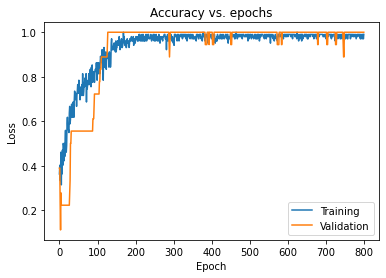

In [31]:
#Run this cell to plot the new accuracy vs epoch graph

try:
    plt.plot(reg_history.history['accuracy'])
    plt.plot(reg_history.history['val_accuracy'])
except KeyError:
    plt.plot(reg_history.history['acc'])
    plt.plot(reg_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

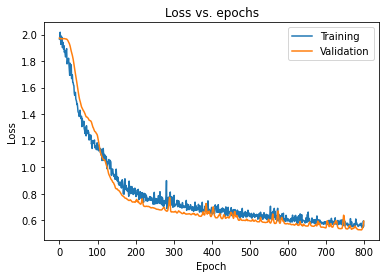

In [32]:
#Run this cell to plot the new loss vs epoch graph

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 